In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy as sp 
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import librosa
import random
import math
#import Torchaudio
import makelab
from makelab import audio
from makelab import signal

In [3]:
def pad_zeros_right(s, padding_length):
    
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)

def pad_mean_right(s, padding_length):
    
    return np.pad(s, (0, padding_length), mode = 'mean')

# def compare_and_plot_signals(a, b, distance_function = distance.euclidean, alignment_function = None):
def plot_signals_with_alignment(a, b, pad_function = None):
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))

    fig, axes = plt.subplots(5, 1, figsize=(10, 18))
    
    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Signals 'a' and 'b'")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)

    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-Correlation Result | Best Match Index: {best_correlation_index} Signal 'b' Shift Amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    b_shifted_mean_fill = makelab.signal.shift_array(b, shift_amount, np.mean(b))
    axes[2].plot(a, alpha=0.7, label="a", marker="o")
    axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker="D")
    axes[2].legend()
    axes[2].set_title("Signals 'a' and 'b_shifted_mean_fill'")
    
    b_shifted_zero_fill = makelab.signal.shift_array(b, shift_amount, 0)
    axes[3].plot(a, alpha=0.7, label="a", marker="o")
    axes[3].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker="D")
    axes[3].legend()
    axes[3].set_title("Signals 'a' and 'b_shifted_zero_fill'")
    
    b_shifted_roll = np.roll(b, shift_amount)
    axes[4].plot(a, alpha=0.7, label="a", marker="o")
    axes[4].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker="D")
    axes[4].legend()
    axes[4].set_title("Signals 'a' and 'b_shifted_roll'")
    
    fig.tight_layout()
    
def compare_and_plot_signals_with_alignment(a, b, bshift_method = 'mean_fill', pad_function = None):
    '''Aligns signals using cross correlation and then plots
    
       bshift_method can be: 'mean_fill', 'zero_fill', 'roll', or 'all'. Defaults to 'mean_fill'
    '''
    
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))
    
    euclid_distance_a_to_b = distance.euclidean(a, b)
    
    num_charts = 3
    chart_height = 3.6
    if bshift_method is 'all':
        num_charts = 5
    
    fig, axes = plt.subplots(num_charts, 1, figsize=(10, num_charts * chart_height))
    
    # Turn on markers only if < 50 points
    a_marker = None
    b_marker = None
    if len(a) < 50:
        a_marker = "o"
        b_marker = "D"
        
    axes[0].plot(a, alpha=0.7, label="a", marker=a_marker)
    axes[0].plot(b, alpha=0.7, label="b", marker=b_marker)
    axes[0].legend()
    axes[0].set_title(f"Raw Signals | Euclidean Distance From 'a' to 'b' = {euclid_distance_a_to_b:.2f}")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)
    
    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    #axes[1].plot(shift_positions, correlate_result)
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-correlation result | Best match index: {best_correlation_index}; Signal 'b' shift amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    if bshift_method is 'mean_fill' or bshift_method is 'all':
        b_shifted_mean_fill = makelab.signal.shift_array(b, shift_amount, np.mean(b))
        euclid_distance_a_to_b_shifted_mean_fill = distance.euclidean(a, b_shifted_mean_fill)
        axes[2].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker=b_marker)
        axes[2].legend()
        axes[2].set_title(f"Euclidean distance From 'a' to 'b_shifted_mean_fill' = {euclid_distance_a_to_b_shifted_mean_fill:.2f}")
    
    ax_idx = 0
    if bshift_method is 'zero_fill' or bshift_method is 'all':
        if bshift_method is 'zero_fill':
            ax_idx = 2
        else:
            ax_idx = 3
    
        b_shifted_zero_fill = makelab.signal.shift_array(b, shift_amount, 0)
        euclid_distance_a_to_b_shifted_zero_fill = distance.euclidean(a, b_shifted_zero_fill)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_zero_fill' = {euclid_distance_a_to_b_shifted_zero_fill:.2f}")
    
    
    if bshift_method is 'roll' or bshift_method is 'all':
        if bshift_method is 'roll':
            ax_idx = 2
        else:
            ax_idx = 4
        b_shifted_roll = np.roll(b, shift_amount)
        euclid_distance_a_to_b_shifted_roll = distance.euclidean(a, b_shifted_roll)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_roll' = {euclid_distance_a_to_b_shifted_roll:.2f}")
    
    fig.tight_layout()
    

<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:139: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:139: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:163: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:139: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:139: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean 

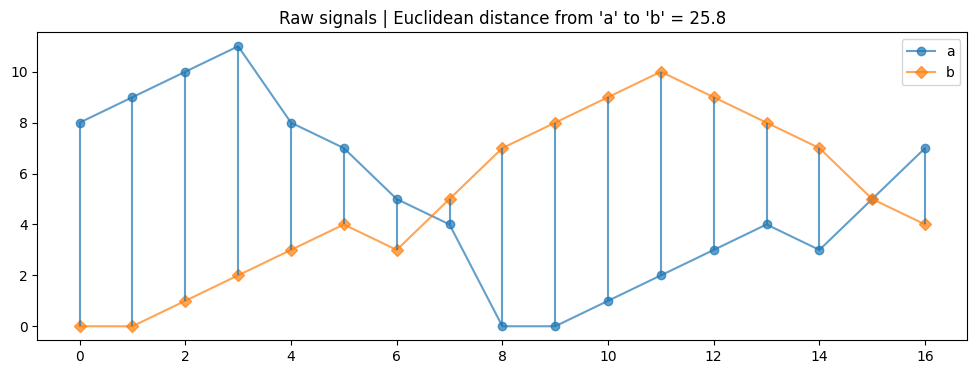

In [4]:
a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

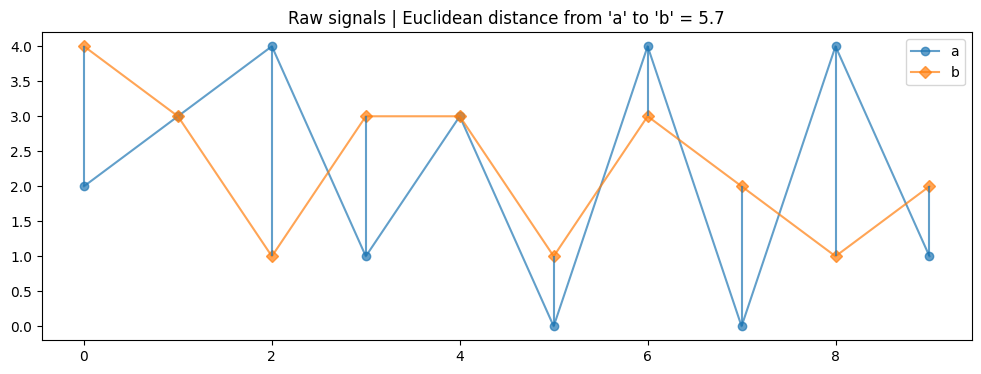

In [5]:
np.random.seed(None)
a = np.random.randint(0, 5, 10)
b = np.random.randint(0, 5, 10)

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

In [6]:
# This cell will throw an error demonstrating that distance.euclidean
# only works with the same sized arrays

a = [0, 1, 2, 3, 4, 5, 6, 7]
b = [3, 4, 5]
euclid_distance_a_to_b = distance.euclidean(a, b)

ValueError: operands could not be broadcast together with shapes (8,) (3,) 

In [ ]:
# #calculate the Euclidean distance between two signals
# a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
# b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]
# euclid_distance_a_to_b = distance.euclidean(a, b)
# print("Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b))



Euclidean distance from 'a' to 'b' = 25.8


In [ ]:
a = [0, 1, 2, 3, 4, 5, 6, 7]
b = [3, 4, 5]

padding_length = len(a) - len(b)

# Pad using zero to the right of the array
b_padded_zero_right = np.pad(b, (0, padding_length), mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_right, len(b_padded_zero_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 0 0 0 0 0] 8


In [ ]:
# Pad with constant value zero to left of the array
b_padded_zero_left = np.pad(b, (padding_length, 0), mode = 'constant', constant_values=0)

print(a, len(a))
print(b, len(b))
print(b_padded_zero_left, len(b_padded_zero_left))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 0 0 0 3 4 5] 8


In [ ]:
# Pad with zero in both directions
b_padded_zero_bothdirs = np.pad(b, (math.floor(padding_length/2.0), math.ceil(padding_length/2.0)), 
                                mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_bothdirs, len(b_padded_zero_bothdirs))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 3 4 5 0 0 0] 8


In [ ]:
# Pad to the right with the mean of 'b'
b_padded_mean_right = np.pad(b, (0, padding_length), mode = 'mean')

print(a, len(a))
print(b, len(b))
print(b_padded_mean_right, len(b_padded_mean_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 4 4 4 4 4] 8


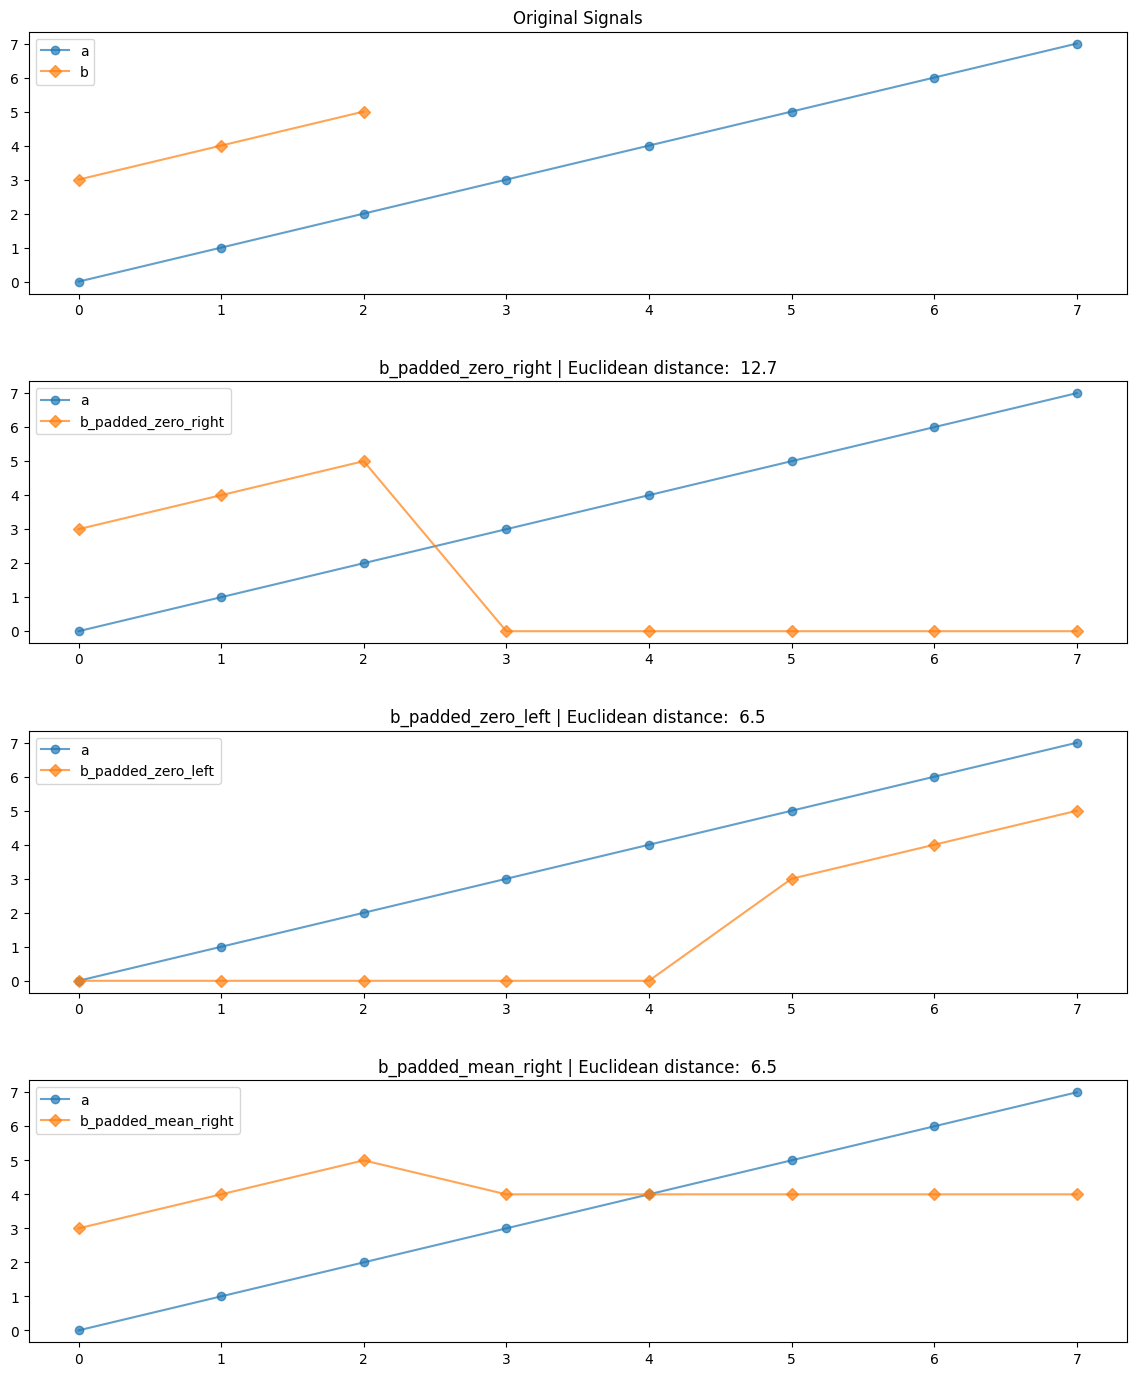

In [ ]:
num_charts = 4
chart_height = 3.6
fig, axes = plt.subplots(num_charts, 1, figsize=(12, num_charts * chart_height))
    
# Turn on markers only if < 50 points
a_marker = None
b_marker = None
if len(a) < 50:
    a_marker = "o"
    b_marker = "D"

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title(f"Original Signals")

axes[1].plot(a, alpha=0.7, label="a", marker="o")
axes[1].plot(b_padded_zero_right, alpha=0.7, label="b_padded_zero_right", marker="D")
axes[1].legend()
axes[1].set_title(f"b_padded_zero_right | Euclidean distance: {distance.euclidean(a, b_padded_zero_right): .1f}")

axes[2].plot(a, alpha=0.7, label="a", marker="o")
axes[2].plot(b_padded_zero_left, alpha=0.7, label="b_padded_zero_left", marker="D")
axes[2].legend()
axes[2].set_title(f"b_padded_zero_left | Euclidean distance: {distance.euclidean(a, b_padded_zero_left): .1f}")

axes[3].plot(a, alpha=0.7, label="a", marker="o")
axes[3].plot(b_padded_mean_right, alpha=0.7, label="b_padded_mean_right", marker="D")
axes[3].legend()
axes[3].set_title(f"b_padded_mean_right | Euclidean distance: {distance.euclidean(a, b_padded_mean_right): .1f}")

fig.tight_layout(pad=3)

In [ ]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
correlate_result = np.correlate(a, b, 'full')
b_shift_positions = np.arange(-len(a) + 1, len(b))
print(b_shift_positions) # The shift positions of b
print(correlate_result)

[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]


In [ ]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
correlate_result = np.correlate(a, b, 'full')
b_shift_positions = np.arange(-len(a) + 1, len(b))
print(b_shift_positions) # The shift positions of b
print(correlate_result)

[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]


len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

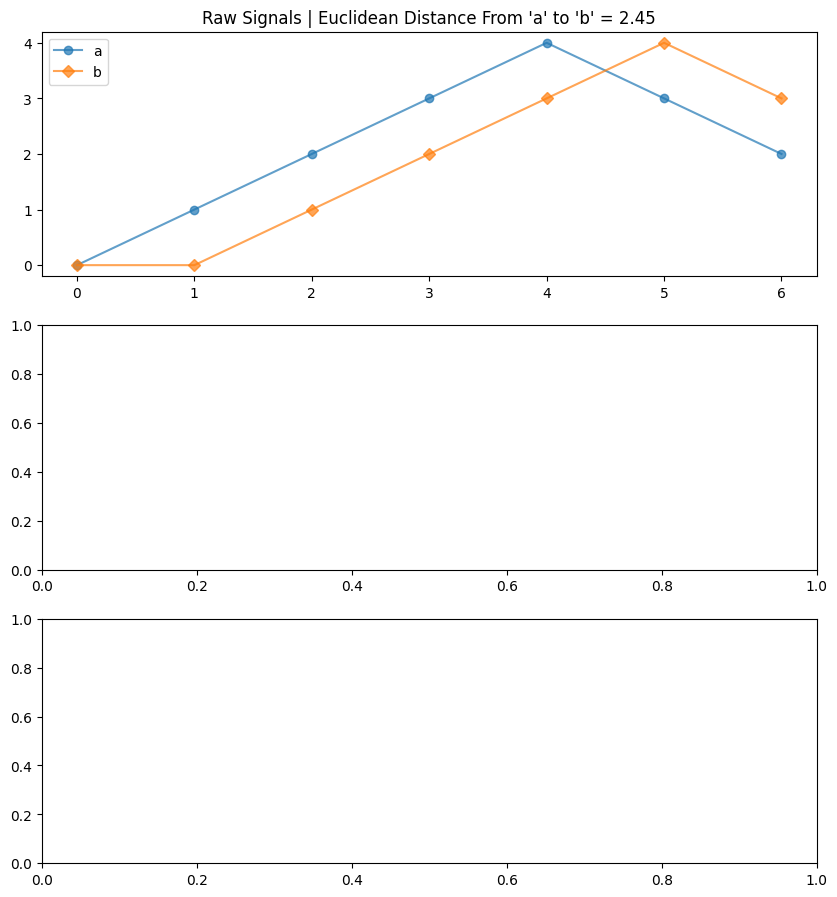

In [ ]:
compare_and_plot_signals_with_alignment(a, b)

In [ ]:
#plot the signals and their cross-correlation
plot_signals_with_alignment(a, b)


NameError: name 'plot_signals_with_alignment' is not defined